# Imports

In [67]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Load and Prepare Dataset

In [68]:
# csv file name
file_name = "3425_data (2).csv"

# read data
df = pd.read_csv(file_name)

# make a subset of df which has columns that will be used
cols = ["A1", "p_gender_sdc", "p_age_group_sdc", "p_education_sdc", "E14"]
df1 = df[cols]

# remove any rows with ”NaN”
df1 = df1.drop(index=df1.index[df1["p_gender_sdc"]== "”NaN”"]).reset_index(drop=True)

# remove any rows with -98, -99
idx = np.logical_or(df1 == -98, df1 == -99)
idx = np.sum(idx, axis=1)
df1 = df1.drop(index=idx.index[idx >= 1]).reset_index(drop=True)

# remove nans
df1 = df1.dropna().reset_index(drop=True)

# one-hot encoding for gender
df1 = pd.concat([df1, pd.get_dummies(df1["p_gender_sdc"], prefix="gender")], axis=1) 
df1 = df1.drop(columns="p_gender_sdc")

# one-hot encoding for education
df1 = pd.concat([df1, pd.get_dummies(df1["p_education_sdc"], prefix="edu")], axis=1) 
df1 = df1.drop(columns="p_education_sdc")

# one-hot encoding for age
df1 = pd.concat([df1, pd.get_dummies(df1["p_age_group_sdc"], prefix="age")], axis=1) 
df1 = df1.drop(columns="p_age_group_sdc")

# one-hot encoding for income
df1 = pd.concat([df1, pd.get_dummies(df1["E14"], prefix="income")], axis=1) 
df1 = df1.drop(columns="E14")

# combine class 1-2 and 4-5
m = {1: 1, 2: 1, 3: 10, 4:2, 5: 2 }
df1.A1 = df1.A1.map(m)

df1 = df1.loc[df1.A1 != 10, :]

# show final df
df1

,A1,gender_”1”,gender_”2”,edu_1,edu_2,edu_3,age_1.0,age_2.0,age_3.0,age_4.0,income_1,income_2,income_3,income_4
0,1,0,1,1,0,0,0,0,0,1,0,1,0,0
1,1,0,1,1,0,0,0,0,0,1,0,1,0,0
2,2,1,0,0,1,0,0,1,0,0,0,1,0,0
3,1,0,1,0,1,0,0,0,0,1,0,1,0,0
4,1,1,0,0,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,1,0,1,0,1,0,0,0,1,0,0,1,0,0
2948,1,1,0,1,0,0,0,1,0,0,1,0,0,0
2949,1,0,1,1,0,0,1,0,0,0,0,1,0,0
2950,1,1,0,1,0,0,0,1,0,0,1,0,0,0


# Classification using LogReg

In [69]:
# targets
y = df1["A1"].values

# features
X = df1.drop(columns="A1").values

# standardize features
X = StandardScaler().fit_transform(X)

# divide data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# over-sample minority class
X_train = np.concatenate((X_train, X_train[y_train == 2], X_train[y_train == 2]))
y_train = np.concatenate((y_train, y_train[y_train == 2], y_train[y_train == 2]))

# use grid search to optimize parameters
# classifier
clf = LogisticRegression(fit_intercept=True, class_weight="balanced")

# values for tuning
param = {"C": np.logspace(-3,3,7),
         "penalty": ["l1", "l2"],
         "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# fit
cv = GridSearchCV(clf, param, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.7s finished


# Report Accuracy

Accuracy: 0.5857


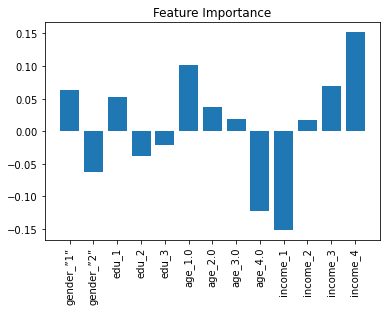

Feature Importance
gender_”1” : 0.062
gender_”2” : -0.062
edu_1 : 0.053
edu_2 : -0.039
edu_3 : -0.020
age_1.0 : 0.101
age_2.0 : 0.037
age_3.0 : 0.018
age_4.0 : -0.123
income_1 : -0.151
income_2 : 0.018
income_3 : 0.069
income_4 : 0.152


In [70]:
y_pred = cv.predict(X_test)
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# show feature importance
plt.bar(df1.columns[1:], cv.best_estimator_.coef_[0])
plt.xticks(rotation='vertical')
plt.title("Feature Importance")
plt.show()


# print feature importance
print("Feature Importance")
for i, importance in enumerate(cv.best_estimator_.coef_[0]):
    print(df1.columns[i+1], ": {:.3f}".format(importance))

# Classification Using Decision Trees

In [71]:
# classifier
clf = DecisionTreeClassifier()

# values tuning
param = {"criterion": ["gini", "entropy"],
         "max_depth": np.arange(1, 11),
         "min_samples_split": np.arange(1, 11),
         "min_samples_leaf": np.arange(1, 6)}

# fit
cv = GridSearchCV(clf, param, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.1s finished


# Report Accuracy

Accuracy: 0.6095


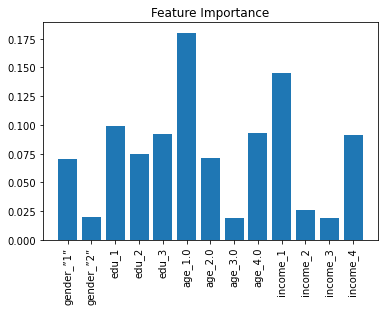

gender_”1” : 0.070
gender_”2” : 0.019
edu_1 : 0.099
edu_2 : 0.074
edu_3 : 0.092
age_1.0 : 0.180
age_2.0 : 0.071
age_3.0 : 0.019
age_4.0 : 0.093
income_1 : 0.146
income_2 : 0.026
income_3 : 0.019
income_4 : 0.091


In [72]:
y_pred = cv.predict(X_test)
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# show feature importance
plt.bar(df1.columns[1:], cv.best_estimator_.feature_importances_)
plt.xticks(rotation='vertical')
plt.title("Feature Importance")
plt.show()

# print feature importance
for i, importance in enumerate(cv.best_estimator_.feature_importances_):
    print(df1.columns[i+1], ": {:.3f}".format(importance))

# Classification using Gradient Boosting

In [73]:
# classifier
clf = GradientBoostingClassifier()

# values tuning
param = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

# fit
cv = GridSearchCV(clf, param, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished


# Report Accuracy

Accuracy: 0.6163


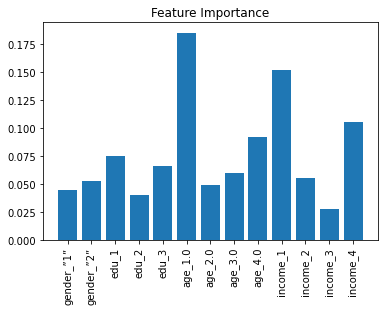

gender_”1” : 0.044
gender_”2” : 0.052
edu_1 : 0.075
edu_2 : 0.040
edu_3 : 0.066
age_1.0 : 0.185
age_2.0 : 0.049
age_3.0 : 0.060
age_4.0 : 0.092
income_1 : 0.151
income_2 : 0.055
income_3 : 0.027
income_4 : 0.105


In [74]:
y_pred = cv.predict(X_test)
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# show feature importance
plt.bar(df1.columns[1:], cv.best_estimator_.feature_importances_)
plt.xticks(rotation='vertical')
plt.title("Feature Importance")
plt.show()

# print feature importance
for i, importance in enumerate(cv.best_estimator_.feature_importances_):
    print(df1.columns[i+1], ": {:.3f}".format(importance))